# Implementación de YOLOv5 con OpenCV

### Instalar onnx.
Herramienta para modelos de Machine Learning

In [ ]:
!pip install onnx

### Librerías

In [9]:
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt

En particular usaremos extensivamente el paquete y funciones ```cv2.dnn``` que permiten implementar yolo de una manera muy fácil y sencilla en cualquier aplicación escrita en Python donde se trabaje con imágenes. 

Primero necesitamos cargar los nombres de las clases en las que se ha entrenado la red. Ten en cuenta que la red que utilicemos solo podrá reconocer las clases en las que se ha formado.

In [10]:
labelsPath = "./yolo-coco/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

Observemos los nombres de algunas clases

In [11]:
LABELS[0:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

Ahora generaremos un color para cada clase

In [12]:
# Cambiar semilla de números pseudo-aleatorios
np.random.seed(42)
# Color para cada clase
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

Observemos el color de cada clase

In [13]:
COLORS[0:5]

array([[102, 220, 225],
       [ 95, 179,  61],
       [234, 203,  92],
       [  3,  98, 243],
       [ 14, 149, 245]], dtype=uint8)

Cargamos nuestro modelo de Yolo

In [22]:
modelPath = "./yolo-coco/yolov5s.onnx"

print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNet(modelPath)

[INFO] loading YOLO from disk...


Ahora cargamos la imagen que queremos analizar

In [25]:
# Función para hacer una imagen cuadrada
def format_yolov5(frame):
    row, col, _ = frame.shape
    _max = max(col, row)
    result = np.zeros((_max, _max, 3), np.uint8)
    result[0:row, 0:col] = frame
    return result

image = cv2.imread("./images/test/dog_yolo.jpg")
original_image = cv2.imread("./images/test/dog_yolo.jpg")
input_image = format_yolov5(image)

Ahora necesitamos cambiar el tamaño de la imagen a un cuadrado 640x640 píxeles y hacer un pase hacia adelante de la red

In [30]:
blob = cv2.dnn.blobFromImage(input_image, 1 / 255.0, (640, 640), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward()
end = time.time()

# Mostrar el tiempo en el que se ejecuto el Forward
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 0.313295 seconds


Ahora vamos a seleccionar los cuadros delimitadores.

In [33]:
class_ids = []
confidences = []
boxes = []

In [31]:
output_data = layerOutputs[0]

In [34]:
image_width, image_height, _ = input_image.shape
x_factor = image_width / 640
y_factor =  image_height / 640

# Hacemos un bucle para cada una de las detecciones
for r in range(len(output_data)):
    row = output_data[r]
    confidence = row[4]

    if confidence >= 0.4:

        classes_scores = row[5:]
        _, _, _, max_indx = cv2.minMaxLoc(classes_scores)
        class_id = max_indx[1]
        if (classes_scores[class_id] > .25):
            """Escalar las coordenadas del cuadro delimitador hacia atrás en relación con el
            tamaño de la imagen, teniendo en cuenta que YOLO en realidad
            devuelve las coordenadas del centro (x, y) del límite
            cuadro seguido del ancho y alto de los cuadros."""
            
            confidences.append(confidence)
            class_ids.append(class_id)

            x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item() 
            
            left = int((x - 0.5 * w) * x_factor)
            top = int((y - 0.5 * h) * y_factor)
            width = int(w * x_factor)
            height = int(h * y_factor)
            
            box = np.array([left, top, width, height])
            boxes.append(box)

In [35]:
# aplicar supresión no máxima para suprimir cuadros delimitadores débiles y superpuestos
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.6,0.2)

In [36]:
# asegúrese de que exista al menos una detección
if len(idxs) > 0:
    # bucle sobre los índices que estamos manteniendo
    for i in idxs.flatten():
        # extraer las coordenadas del cuadro delimitador
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # dibuje un rectángulo de cuadro delimitador y una etiqueta en la imagen
        color = [int(c) for c in COLORS[class_ids[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 20)
        text = "{}: {:.4f}".format(LABELS[class_ids[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 12)

Mostramos la imagen con las detecciones y la guardamos

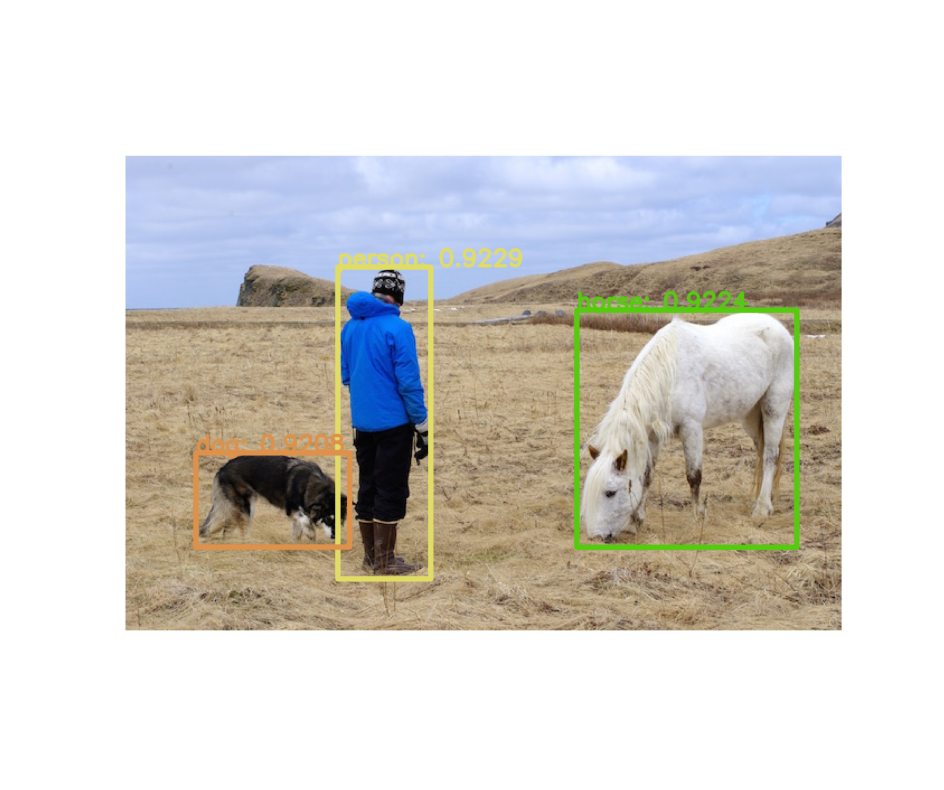

In [39]:
fig = plt.figure(figsize = (12,10))
plt.imshow(image[:,:,::-1])
plt.axis('off')
plt.savefig('./images/detection/dog_yolo.jpg', dpi = 300)

Mostramos la imagen original y la guardamos

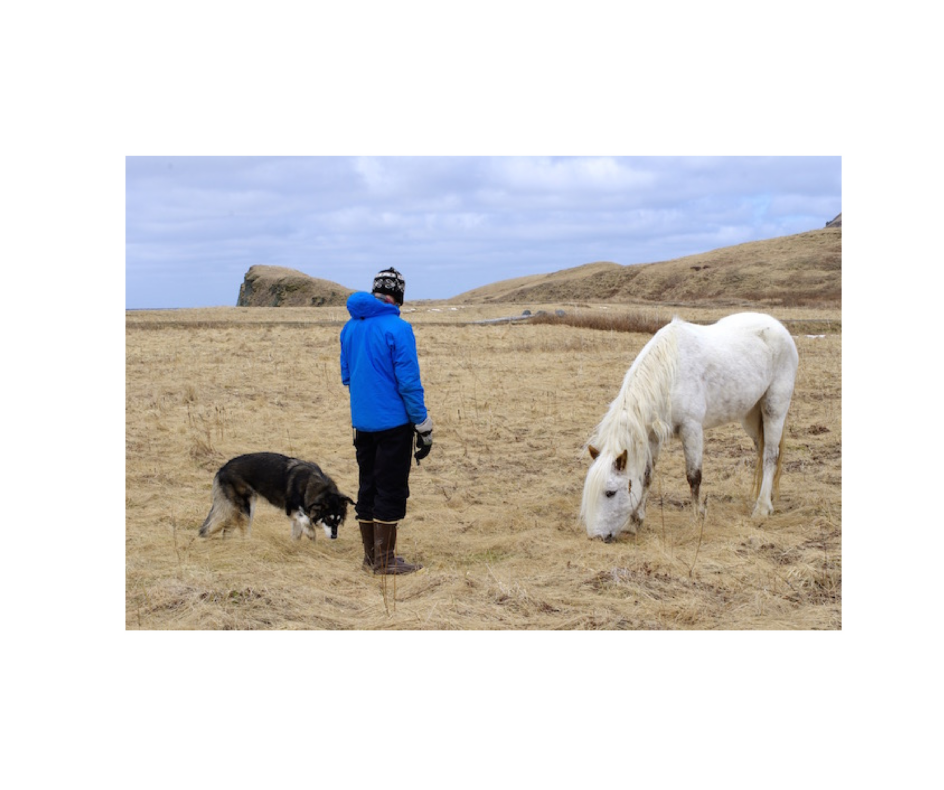

In [40]:
plt.figure(figsize = (12,10))
plt.imshow(original_image[:,:,::-1])

plt.axis('off')
plt.savefig('./images/detection/dog_orig.jpg', dpi = 300)